In [1]:
!pip install openpyxl

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.weightstats import ztest
import warnings

In [3]:
path_to_file = '../data/Grocery Database.xlsx'

In [4]:
df = pd.read_excel(path_to_file)

# Initial Data Analysis

1.Let's display the first 3 records from the dataset, the data types in the dataset df, and the dataset dimensions:

In [5]:
display(df.head(3), df.dtypes, df.shape)

,Receipt Number,Date,Year,Month,Time,Mobile Number,Membership ID,Loyalty Card Points,Age,Gender,...,GST,Gross Bill Amount,Payment Mode,Bank Name,% Profit Margin,% Operating Cost,% Product Cost,Profit Margin,Operating Cost,Product Cost
0,GIJ00001,2016-01-02,2016,1,10:08:03.260000,9793548581,MIDID0001,1,36,Male,...,0.1,13.32408,Card,Enterprise Bank,0.150,0.15,0.700,1.85400,1.8540,8.65200
1,GIJ00002,2016-01-02,2016,1,15:46:50.832000,9938441276,MIDID0002,2,54,Male,...,0.1,25.26480,Card,Philippine Veterans Bank,0.118,0.15,0.732,2.73760,3.4800,16.98240
2,GIJ00003,2016-01-02,2016,1,11:28:52.166000,9976742552,MIDID0003,1,16,Female,...,0.1,42.18786,Cash,BDO Unibank,0.147,0.15,0.703,1.95657,1.9965,9.35693


Receipt Number                 object
Date                   datetime64[ns]
Year                            int64
Month                           int64
Time                           object
Mobile Number                   int64
Membership ID                  object
Loyalty Card Points             int64
Age                             int64
Gender                         object
City                           object
Country                        object
Category                       object
Sub_Category                   object
Items                          object
Brand                          object
Description                    object
Price                         float64
QTY                             int64
DISC                          float64
Amount                        float64
Net Bill Amount               float64
GST                           float64
Gross Bill Amount             float64
Payment Mode                   object
Bank Name                      object
% Profit Mar

(50447, 32)

2.Let's check if there are any missing values in this dataset:

In [6]:
df.isna().sum()

Receipt Number         0
Date                   0
Year                   0
Month                  0
Time                   0
Mobile Number          0
Membership ID          0
Loyalty Card Points    0
Age                    0
Gender                 0
City                   0
Country                0
Category               0
Sub_Category           0
Items                  0
Brand                  0
Description            0
Price                  0
QTY                    0
DISC                   0
Amount                 0
Net Bill Amount        0
GST                    0
Gross Bill Amount      0
Payment Mode           0
Bank Name              0
% Profit Margin        0
% Operating Cost       0
% Product Cost         0
Profit Margin          0
Operating Cost         0
Product Cost           0
dtype: int64

3.Verification of the accuracy of purchase data:

In [7]:
df_clean = df.copy()

# Verification of selected receipts
def amount_checker(receipt_number, dataframe):
    net_bill_amount = round(dataframe[dataframe['Receipt Number'] == receipt_number]['Net Bill Amount'].unique()[0], 4)
    total_amount = round(dataframe[dataframe['Receipt Number'] == receipt_number]['Amount'].sum(), 4)
    
    if net_bill_amount == total_amount:
        print(f"The sum of Net Bill Amount in the dataset equals {net_bill_amount}. The recalculation also gives us {total_amount}.")
    else:
        print(f"The sum of Net Bill Amount in the dataset does not equal the total Amount for a given receipt..")

amount_checker('GIJ00003', df_clean)
amount_checker('GIJ00004', df_clean)
amount_checker('GSW01533', df_clean)


# Counting the total number of rows with discrepancies
check_amount_by_receipt = df_clean.groupby('Receipt Number').agg({'Net Bill Amount': 'first', 'Amount': 'sum'})
check_amount_by_receipt['Check'] = check_amount_by_receipt['Net Bill Amount'] == check_amount_by_receipt['Amount']

print(f'\nResult: {check_amount_by_receipt.Check.value_counts()}')

The sum of Net Bill Amount in the dataset does not equal the total Amount for a given receipt..
The sum of Net Bill Amount in the dataset does not equal the total Amount for a given receipt..
The sum of Net Bill Amount in the dataset equals 74.1664. The recalculation also gives us 74.1664.

Result: Check
True     8521
False    4527
Name: count, dtype: int64


In [8]:
df['Net Bill Amount'] = df.groupby('Receipt Number')['Amount'].transform('sum')
df['Gross Bill Amount'] = df['Net Bill Amount'] + df['Net Bill Amount']*df['GST']

In [9]:
df[df['Receipt Number'] == 'GIJ00008']['Net Bill Amount'].unique()

array([123.0096])

In [10]:
df[df['Receipt Number'] == 'GIJ00008'].Amount.sum()

123.0096

4.Let's display a list of countries and cities for further analysis:

In [11]:
display(df.Country.unique(), df.City.unique())

array(['Indonesia', 'Malaysia', 'Philippines', 'Singapore'], dtype=object)

array(['Jakarta', 'Kuala Lumpur', 'Manila', 'Bedok', 'Woodlands'],
      dtype=object)

# Data Analysis

**Q1**
Let's explore the cities and their revenue each year.

In [12]:
city_pivot = df.pivot_table(index = 'Year', columns = 'City', values = 'Profit Margin', aggfunc = 'sum')
round(city_pivot, 1)

City,Bedok,Jakarta,Kuala Lumpur,Manila,Woodlands
Year,,,,,
2016,3158.3,2395.6,2558.1,2621.0,1588.1
2017,3347.2,2600.1,2863.7,3221.4,1686.9
2018,3773.2,2812.8,3400.3,3852.6,1951.4
2019,4371.0,3260.1,4136.0,4760.6,2263.0


We see that in each city, revenue increases year by year accordingly. It is apparent that the cities Bedok and Manila are leading.

**Q2**
Create a chart to visually explore the profit generated by the cities.

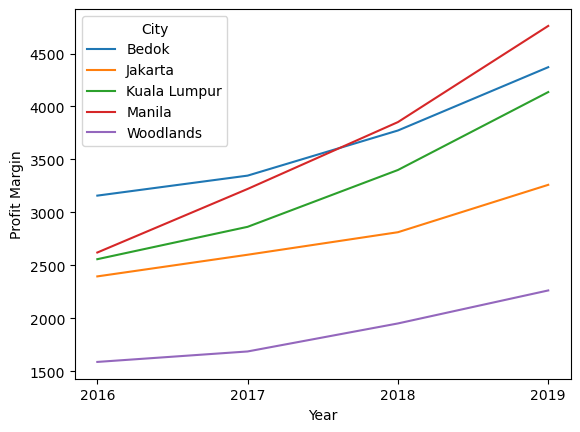

In [13]:
city_pivot.plot(xticks = city_pivot.index, ylabel = 'Profit Margin');

The cities Bedok and Manila are leading. The correlation for each city is positive.

**Q3**
Calculate the total profit from each country.

In [14]:
round(df.groupby(['City'])['Profit Margin'].sum().sort_values(ascending = False).reset_index(), 2)

,City,Profit Margin
0,Bedok,14649.60
1,Manila,14455.63
2,Kuala Lumpur,12958.12
3,Jakarta,11068.60
4,Woodlands,7489.30


We see that the most profitable cities by total profit are Bedok and Manila.

**Q4**
Calculate the total profit from each city by month.

In [15]:
month_pivot = df.pivot_table(index = 'Month', columns = 'City', values = 'Profit Margin', aggfunc = 'sum')
round(month_pivot, 2)

City,Bedok,Jakarta,Kuala Lumpur,Manila,Woodlands
Month,,,,,
1,1603.09,806.98,983.83,1154.33,717.86
2,1093.33,880.36,1102.20,1111.22,446.72
3,1183.87,956.61,1045.13,1257.46,528.83
4,1107.51,803.06,1000.02,1113.75,550.86
5,1076.32,994.97,1084.25,1115.44,791.26
6,1247.40,866.11,1067.98,1068.72,587.81
7,1370.07,870.74,1119.98,1207.20,649.94
8,1185.12,759.93,1094.37,1113.46,649.63
9,1015.56,1014.22,1027.56,1169.01,516.77


There is no clear trend, though December stands out slightly (which could be due to Christmas).

**Q5**
Let's look at the receipts for each month to determine if seasonality has an effect.

In [16]:
month_map = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

bill_by_month = df.groupby('Month')['Gross Bill Amount'].sum().reset_index()
bill_by_month['Month'] = bill_by_month['Month'].map(month_map)

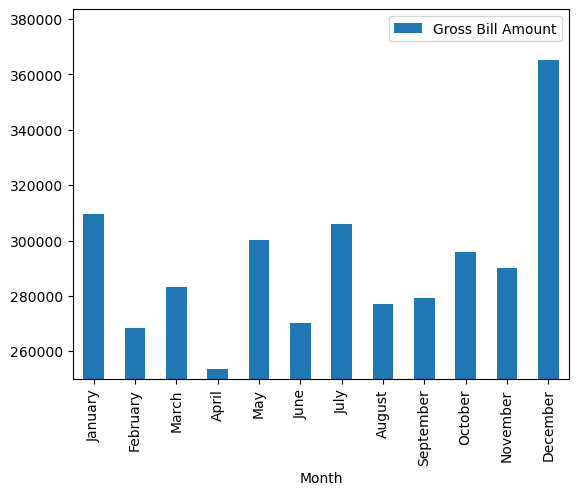

In [17]:
bill_by_month.set_index('Month').plot.bar()
plt.ylim(250000, None);

There is no clear trend, though December stands out slightly (which could be due to Christmas).

**Q6**
What is the number of unique customers?

In [18]:
customers = df['Membership ID'].nunique()
print('Number of unique customers:', customers)

Number of unique customers: 2601


**Q7**
Let's see which gender predominates in making purchases.

In [19]:
df.Gender.value_counts().reset_index()

,Gender,count
0,Female,41822
1,Male,8625


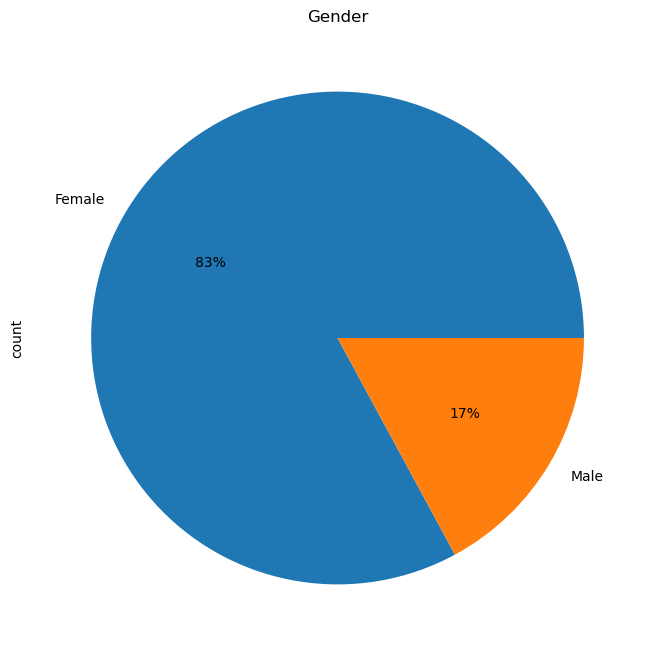

In [20]:
df.Gender.value_counts().plot(kind = 'pie', y = 'Gender', autopct = '%1.0f%%', figsize = (8, 8))
plt.title('Gender');

We see that the number of women significantly predominates.

**Q8**
Let's see which age group of women is the most financially capable.

In [21]:
female_sorted = df[df['Gender'] == 'Female'].groupby('Age')['Gross Bill Amount'].sum()

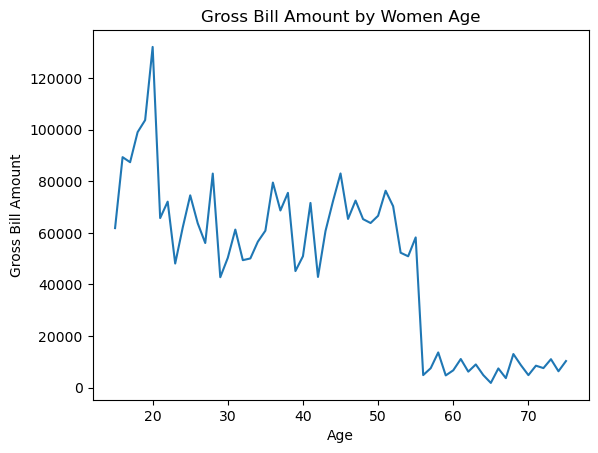

In [22]:
female_sorted.plot( )
plt.ylabel('Gross Bill Amount') 
plt.title('Gross Bill Amount by Women Age') 
plt.show();

From the chart, we see that the average amount of receipts for the middle age group is much higher than for the older age group.

**Q9** Let's group women by categories and see how much profit each category generates and how it differs.

In [23]:
# create 3 age groups
bins = [0, 25, 55, 100]
labels = ['young', 'adult', 'old']
df['Age_bin'] = pd.cut(df['Age'], bins, labels = labels)

In [24]:
# For convenience and logical sequence, add a new column Age_bin after Age
df = df[['Receipt Number', 'Date', 'Year', 'Month', 'Time', 'Mobile Number',
       'Membership ID', 'Loyalty Card Points', 'Age', 'Age_bin', 'Gender', 'City',
       'Country', 'Category', 'Sub_Category', 'Items', 'Brand ',
       'Description ', 'Price', 'QTY', 'DISC', 'Amount', 'Net Bill Amount',
       'GST', 'Gross Bill Amount', 'Payment Mode', 'Bank Name',
       '% Profit Margin', '% Operating Cost', '% Product Cost',
       'Profit Margin', 'Operating Cost', 'Product Cost']]

C:\Users\danets\AppData\Local\Temp\ipykernel_10260\3994290691.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[df['Gender'] == 'Female'].groupby('Age_bin')['Profit Margin'].sum().plot.bar()


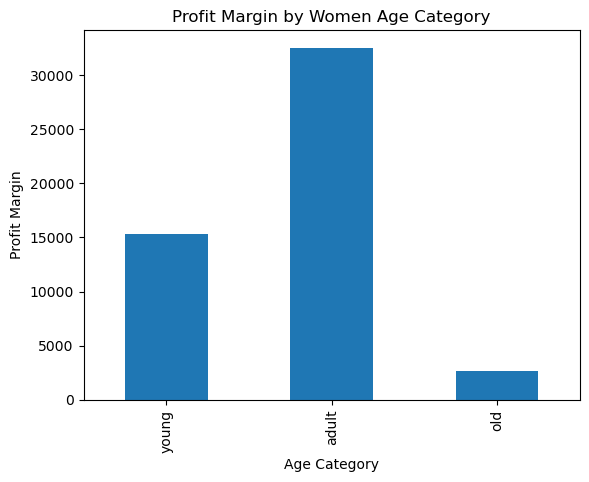

In [25]:
df[df['Gender'] == 'Female'].groupby('Age_bin')['Profit Margin'].sum().plot.bar()
plt.ylabel('Profit Margin')
plt.xlabel('Age Category') 
plt.title('Profit Margin by Women Age Category') 
plt.show();

We can clearly see that the highest profit comes from women in the 25-55 age category. This is our target audience, and it would be interesting to analyze the leading categories within this age group and tailor our advertising campaign accordingly. On the other hand, it is also interesting to explore the 'old' category to understand how we might improve profit from this segment. Perhaps we need to introduce new products that would appeal to this age group.

**Q10**
Let's see which payment methods clients use.

In [26]:
df['Payment Mode'].value_counts().reset_index()

,Payment Mode,count
0,Card,17149
1,Wallet,16867
2,Cash,16431


**Q11** What product categories are the most profitable in the store?

In [27]:
round(df.groupby('Category')['Profit Margin'].sum().sort_values(ascending = False)[:10], 1)

Category
Frozen                    9261.1
Beauty                    7990.0
Bakery & Breakfast        6224.7
Pet Care                  4465.3
Fruit & Vegetable         4388.2
Mother & Baby             4261.7
Meat & Seafood            4166.6
Wines, Beers & Spirits    3653.7
Choco, Snacks, Sweets     2958.1
Dairy, Chilled & Eggs     2668.7
Name: Profit Margin, dtype: float64

**Q12**
What product categories are the most popular in the store?

In [28]:
df.Category.value_counts()[:10]

Category
Bakery & Breakfast           6770
Frozen                       6393
Beauty                       5205
Fruit & Vegetable            4370
Pet Care                     3465
Dairy, Chilled & Eggs        3381
Choco, Snacks, Sweets        3019
Kitchen & Dining             2552
Rice & Cooking Essentials    2432
Beverages                    2208
Name: count, dtype: int64

We see that the most popular categories are Bakery & Breakfast and Frozen

**Q13**
Let's explore the subcategory within the most popular category, Bakery & Breakfast.

In [29]:
df[df.Category == 'Bakery & Breakfast']['Sub_Category'].value_counts(ascending = False)

Sub_Category
Fresh Bread              1608
Sliced Bread             1066
Pastries & Treats        1048
Oatmeals                 1030
Cereal & Protein Bars    1015
Jams, Honey & Spreads    1003
Name: count, dtype: int64

**Q14** Find the item that was purchased the most in the dataframe within the most popular category, Bakery & Breakfast.

In [30]:
df[df.Category == 'Bakery & Breakfast'].groupby('Items')['QTY'].sum().sort_values(ascending = False)[:1]

Items
Original wholemeal bread    957
Name: QTY, dtype: int64

**Q15** Perform a z-test to determine if there is a difference in revenue between the two subcategories, Sliced Bread and Pastries & Treats.

In [31]:
sliced_bread = df[df.Sub_Category == 'Sliced Bread'].pivot_table(index = 'Receipt Number', values = 'Profit Margin', aggfunc = 'sum').values

In [32]:
pastries_treats = df[df.Sub_Category == 'Pastries & Treats'].pivot_table(index = 'Receipt Number', values = 'Profit Margin', aggfunc = 'sum').values

In [33]:
# Null hypothesis (H0): The revenue from the subcategory Sliced Bread is the same as the revenue from the subcategory Pastries & Treats.
# Alternative hypothesis: The revenue differs between the two subcategories.
alpha = 0.05
stat, p_value = ztest(sliced_bread, pastries_treats, value = 0)
print("Z-test")
print("Test statistics:", stat)
print("p-value:", p_value)

Z-test
Test statistics: [14.15501517]
p-value: [1.73900213e-45]


In [34]:
if p_value > alpha:
    print("Based on the results of the z-test, we cannot reject the null hypothesis (H0)")
else:
    print("Based on the results of the z-test, we reject the null hypothesis (H0).")

Based on the results of the z-test, we reject the null hypothesis (H0).


We set the significance level at 5%. The z-statistic for the two samples is 14.155, and the corresponding p-value is 1.73900213e-45. Since the p-value < 0.05, we reject the null hypothesis. In other words, the revenue differs.

In [35]:
print(f'Revenue from the subcategory sliced_bread - {{:.2f}}.\nRevenue from the subcategory pastries_treats - {{:.2f}}.'.format(sliced_bread.sum(), pastries_treats.sum()))

Revenue from the subcategory sliced_bread - 1237.28.
Revenue from the subcategory pastries_treats - 801.47.


**Metrics system/Tableau report**

We are interested in the revenue (margin) that the company generates from each country/city. We will examine the revenue trend over the years and look at the correlation. It will also be interesting to calculate the percentage of revenue contributed by each city. Additionally, we will compare countries to understand where to open new branches, and analyze which categories to develop in which cities, identifying the most profitable ones and those that are not.

You can find the metric system at the following link:
https://docs.google.com/document/d/1mhuNltPZb8mX3o5qjSwfeZtX0ghg9bHTeLcq3zUDQxg/edit?usp=sharing


The visualization in the form of an interactive data report can be found at the following link:
https://public.tableau.com/app/profile/maryna.danets/viz/ProfitMargin_17212539303290/ProfitMargin